<a href="https://colab.research.google.com/github/imannainaa/drowsiness_detector/blob/main/Drowsiness_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and Import Dependencies

In [1]:
#install pytorch
!pip install torch torchvision torchaudio

In [2]:
#install yolo
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16413, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 16413 (delta 0), reused 3 (delta 0), pack-reused 16408
Receiving objects: 100% (16413/16413), 14.96 MiB | 24.75 MiB/s, done.
Resolving deltas: 100% (11263/11263), done.


In [3]:
!cd yolov5 & pip install -r /content/yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.5/709.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


In [4]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2

Load Model

In [41]:
#download pretrained model from pytorch hub *ultralytics/yolov5=package *yolov5s=model
model = torch.hub.load('ultralytics/yolov5','yolov5s')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-2-9 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [6]:
model

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

3. Make Detections

In [7]:
img = 'https://paultan.org/image/2016/05/traffic-jam-bernama-630x391.jpg'

In [8]:
results = model(img)
results.print()

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1: 391x630 28 cars, 1 bus, 1 truck
Speed: 184.3ms pre-process, 110.0ms inference, 761.8ms NMS per image at shape (1, 3, 416, 640)


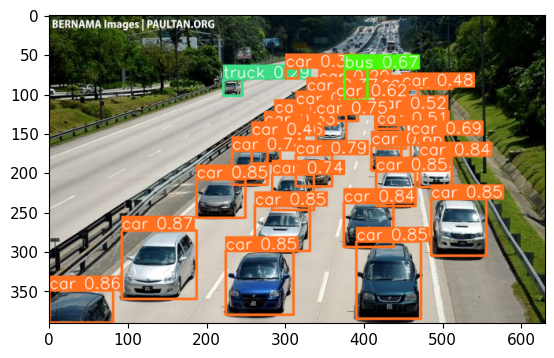

In [9]:
%matplotlib inline
plt.imshow(np.squeeze(results.render()))
plt.show()

4. Real Time Detection

Accessing the webcam to capture picture in real time and make detection

In [10]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [11]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [12]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [13]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


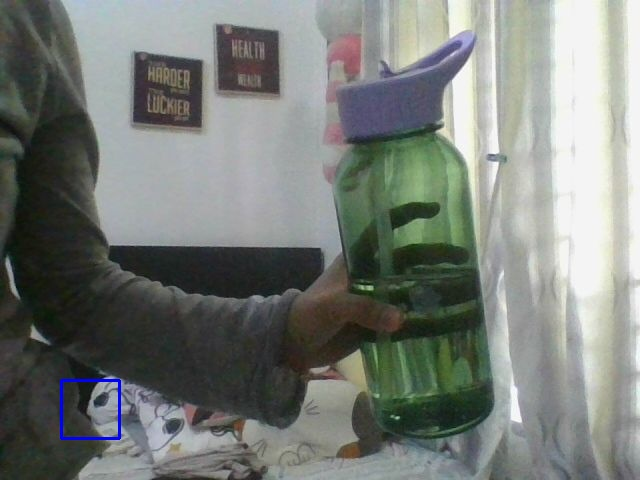

In [42]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [43]:
results = model('photo.jpg')
results.print()

image 1/1: 480x640 1 person, 1 bottle
Speed: 6.6ms pre-process, 79.2ms inference, 1.8ms NMS per image at shape (1, 3, 480, 640)


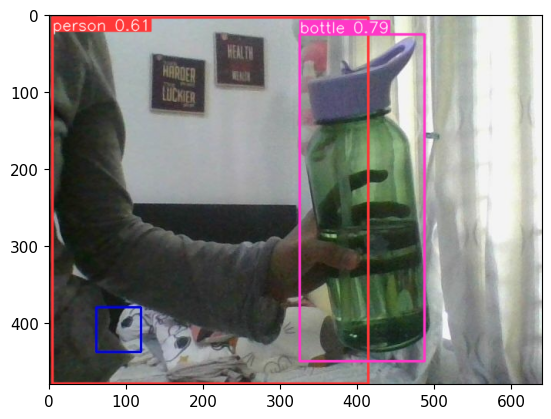

In [44]:
%matplotlib inline
plt.imshow(np.squeeze(results.render()))
plt.show()

5. Train model from scratch

In [15]:
!git clone https://github.com/tzutalin/labelImg

Cloning into 'labelImg'...
remote: Enumerating objects: 2097, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 2097 (delta 0), reused 4 (delta 0), pack-reused 2090
Receiving objects: 100% (2097/2097), 237.14 MiB | 49.16 MiB/s, done.
Resolving deltas: 100% (1245/1245), done.


In [16]:
!pip install pyqt5 lxml --upgrade
!cd labelImg && pyrcc5 -o libs/resources.py resources.qrc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 10.0 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 4.9.4
    Uninstalling lxml-4.9.4:
      Successfully uninstalled lxml-4.9.4


In [17]:
!cd yolov5 && python train.py --img 320 --batch 16 --epochs 500 --data dataset.yml --weights yolov5s.pt

2024-02-09 07:20:59.082295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 07:20:59.082359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 07:20:59.083850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=dataset.yml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=500, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, op

In [46]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp/weights/best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-2-9 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7055974 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


6. Load and Run Model

In [37]:
import os
img = os.path.join('data', 'images', 'drowsy15.jpeg')

In [38]:
results = model(img)

In [39]:
results.print()

image 1/1: 1280x960 1 drowsy
Speed: 79.6ms pre-process, 21.9ms inference, 1.7ms NMS per image at shape (1, 3, 640, 480)


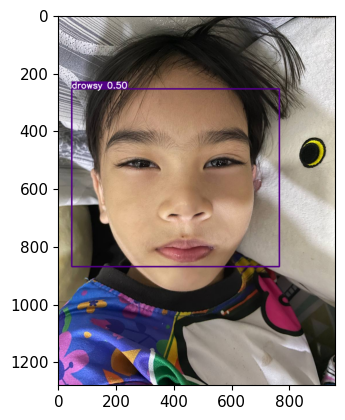

In [40]:
%matplotlib inline
plt.imshow(np.squeeze(results.render()))
plt.show()

Real Time detection

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


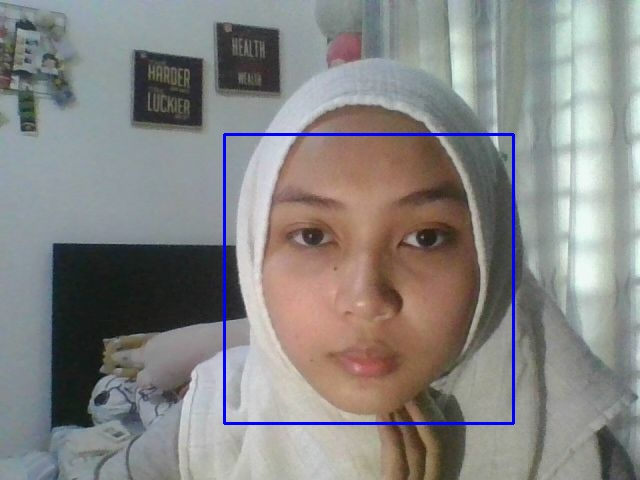

In [52]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [53]:
results = model('photo.jpg')
results.print()

image 1/1: 480x640 1 awake
Speed: 7.2ms pre-process, 8.2ms inference, 2.3ms NMS per image at shape (1, 3, 480, 640)


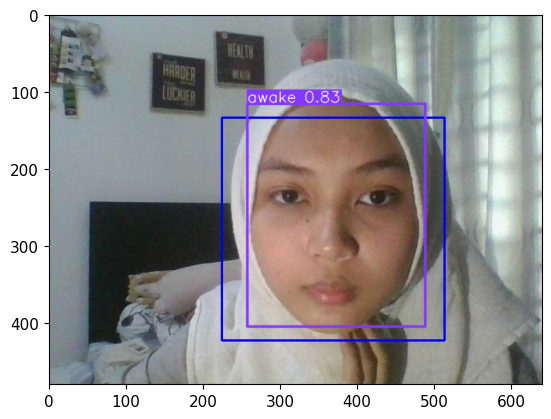

In [54]:
%matplotlib inline
plt.imshow(np.squeeze(results.render()))
plt.show()